In [ ]:
# https://medium.com/@simple.schwarz/how-to-build-a-gan-for-generating-mnist-digits-in-pytorch-b9bf71269da8
import os
import sys
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Thu Feb 22 00:09:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CUDA = True
DATA_PATH = '/content/drive/MyDrive/Data'
BATCH_SIZE = 128
X_DIM = 30
Z_DIM = 100
EPOCH_NUM = 50
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [ ]:
# check cuda
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.0+cu121


In [ ]:
def load_fashion_dataloaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize(X_DIM),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_set = torchvision.datasets.FashionMNIST(
        root=DATA_PATH,
        train=True,
        download=True,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )

    test_set = torchvision.datasets.FashionMNIST(
        root=DATA_PATH,
        train=False,
        download=True,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return train_loader, test_loader

In [ ]:
train_loader, test_loader = load_fashion_dataloaders()

In [ ]:
len(train_loader)

469

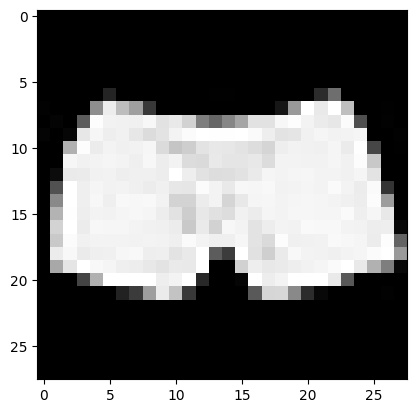

In [ ]:
batch = next(iter(train_loader))
imgs, labels = batch
# imgs.shape
img = imgs[0].squeeze().numpy()
plt.imshow(img, "gray")

# Weight initialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# MODEl

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu=4, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu=4, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# load the pretrained data

generator_checkpoint = torch.load('/content/drive/MyDrive/Data/generator_weights_epoch20.pth')
discriminator_checkpoint = torch.load('/content/drive/MyDrive/Data/discriminator_weights_epoch20.pth')

netG = Generator().to(device)
netD = Discriminator().to(device)

netG.load_state_dict(generator_checkpoint)
netD.load_state_dict(discriminator_checkpoint)
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(train_loader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 400 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/469]	Loss_D: 0.6079	Loss_G: 1.5503	D(x): 0.7078	D(G(z)): 0.1391 / 0.3511
[0/50][200/469]	Loss_D: 0.3809	Loss_G: 2.7192	D(x): 0.8104	D(G(z)): 0.1249 / 0.0896
[0/50][400/469]	Loss_D: 0.2687	Loss_G: 3.0860	D(x): 0.8849	D(G(z)): 0.1200 / 0.0612
[1/50][0/469]	Loss_D: 0.2201	Loss_G: 2.8805	D(x): 0.9347	D(G(z)): 0.1289 / 0.0728
[1/50][200/469]	Loss_D: 0.4755	Loss_G: 1.9589	D(x): 0.7411	D(G(z)): 0.1230 / 0.1884
[1/50][400/469]	Loss_D: 0.6507	Loss_G: 2.2104	D(x): 0.6535	D(G(z)): 0.1191 / 0.1633
[2/50][0/469]	Loss_D: 0.7701	Loss_G: 2.0979	D(x): 0.6172	D(G(z)): 0.1053 / 0.1959
[2/50][200/469]	Loss_D: 0.4989	Loss_G: 2.8846	D(x): 0.8323	D(G(z)): 0.2243 / 0.0789
[2/50][400/469]	Loss_D: 0.5159	Loss_G: 2.3312	D(x): 0.7027	D(G(z)): 0.0907 / 0.1617
[3/50][0/469]	Loss_D: 0.5173	Loss_G: 3.6360	D(x): 0.8706	D(G(z)): 0.2541 / 0.0405
[3/50][200/469]	Loss_D: 0.4490	Loss_G: 3.2157	D(x): 0.9226	D(G(z)): 0.2706 / 0.0551
[3/50][400/469]	Loss_D: 0.3596	Loss_G: 2.6289	D(x): 0.8638

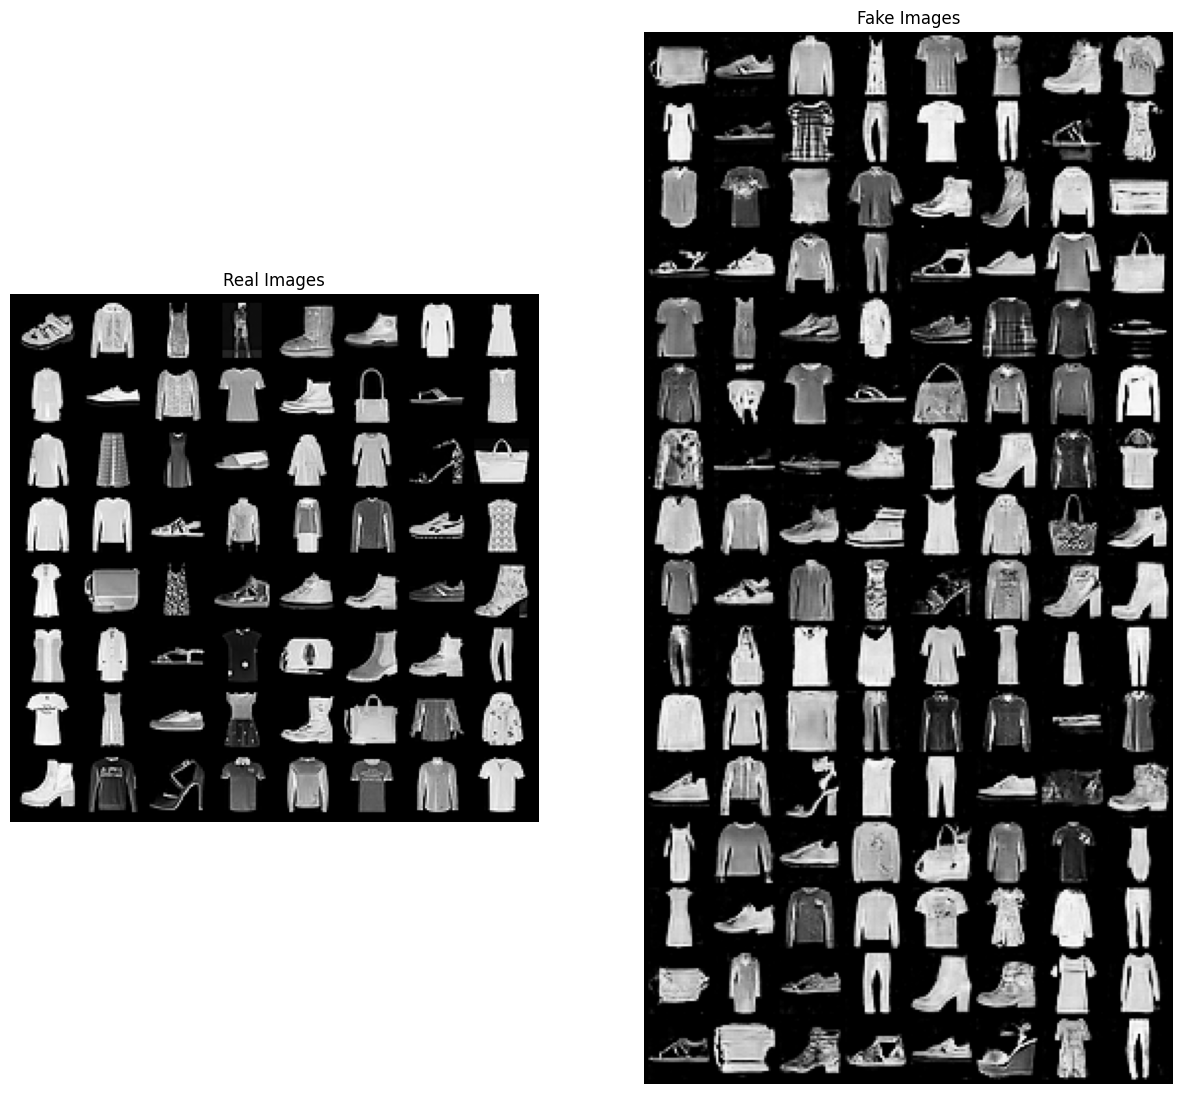

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Overview of the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Overview of the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# save the final trained models

# torch.save(G.state_dict(), 'generator_weights.pth')
torch.save(netG.state_dict(), '/content/drive/MyDrive/Data/generator_weights_epoch70.pth')
torch.save(netD.state_dict(), '/content/drive/MyDrive/Data/discriminator_weights_epoch70.pth')

In [ ]:
type(img_list[0].detach().squeeze().numpy().squeeze())

numpy.ndarray

In [ ]:
img_list[1].shape

torch.Size([3, 482, 242])

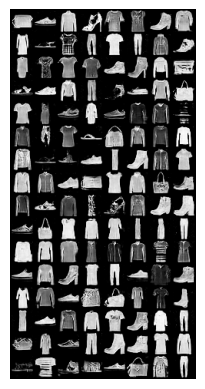

In [ ]:
from PIL import Image

image = transforms.ToPILImage()(img_list[3])

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
for i, img in enumerate(img_list):
    image = transforms.ToPILImage()(img)
    image.save(f'/content/drive/MyDrive/Data/images/generated_image_epoch70_{i}.png')


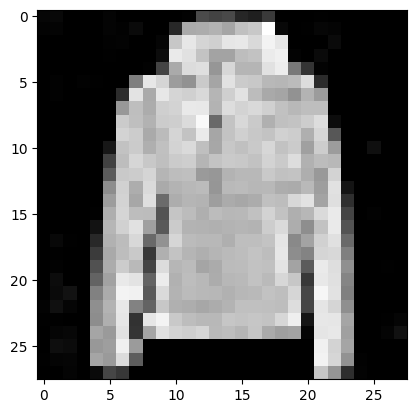

In [ ]:
noise = torch.randn(1, Z_DIM, 1, 1, device=device)
fake = netG(noise)
fake_img = fake.detach().squeeze().numpy()
plt.imshow(fake_img, 'gray')
